In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
from scipy import signal
from pathlib import Path
import h5py
import utils
import sys
import utils
import os
import sys
import mpl_markers as mplm
import pybind_11_ldpc_setup as pbe

np.set_printoptions(suppress=True)

dir_ = Path.cwd()

plt.rc("xtick", direction="inout", labelsize="x-small")
plt.rc("ytick", direction="inout", labelsize="x-small")

%config InlineBackend.figure_formats = ['svg']
from IPython.display import HTML

/mnt/c/Users/rlyon/ee6961/project_part3/.venv/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


# ECE 6961 Wireless Communications
## Project Part 3

Group Members: Grant Brown, Thomas Warren, Rick Lyon

In [2]:
# parameters
K = 2048 # number of subcarriers
Kp = 512 # number of pilot subcarriers
Sn = 112 # number of null subcarriers
Sd = 1420 # number of data subcarriers
L = 200 # number of zero pad samples
Fc = 24e3 # carrier frequency
B = 8e3 # bandwidth
W = 24 # number of OFDM symbols
Wd = 21 # number of data OFDM symbols
sps = 24 # samples per symbol
fs_rx = 256e3 # sampling rate of receiver
fs_tx = 192e3
Ts_rx = 1 / fs_rx # sampling period of receiver
Ts_tx = 1 / fs_tx # sampling period of transmitter
# decoder parameters
LDPC_CHKLEN = 1420
LDPC_CODELEN = 2840

N_RX = 3

# raw recieved data for three hydrophones, benchmark data
bench_rx_data = []
for r in range(1, N_RX + 1):
    f = h5py.File(dir_ / f"data/benchmark_rece_data_172648_{r}.mat",'r')
    bench_rx_data.append(f["rece_data_ofdm_bench"][:].flatten())
min_len = np.min([len(x) for x in bench_rx_data])
bench_rx_data = np.array([x[:min_len] for x in bench_rx_data])

# raw recieved data for three hydrophones, testing data
test_rx_data = []
for r in range(1, N_RX + 1):
    f = h5py.File(dir_ / f"data/testing_rece_data_171846_{r}.mat",'r')
    test_rx_data.append(f["rece_data_ofdm_test"][:].flatten())
min_len = np.min([len(x) for x in test_rx_data])
test_rx_data = np.array([x[:min_len] for x in test_rx_data])

# expected data at receiver for first 21 OFDM symbols
f = loadmat(dir_ / "data/CODE.mat")
CODE = f["CODE"].squeeze()
expected_code = CODE[:, :21].T

# reference data used for debugging
f = h5py.File(dir_ / "data/benchmark_intermediate_172648_from_1_single_hydrophones.mat",'r')
APP_ref = f["APP_OUT"][:]
Le_ref = f["Le_OUT"][:]
hLS_ref = f["hLS"][:]
hLS_ref = hLS_ref["real"] + 1j * hLS_ref["imag"]

# indicies for pilot, null and data subcarriers in the OFDM block
f = h5py.File(dir_ / "data/ofdm_map.mat",'r')
ofdm_map = f["ofdm_map"][:].flatten()
null_subcarrier_i = np.argwhere(ofdm_map == 0).squeeze()
pilot_subcarrier_i = np.argwhere(ofdm_map == 1).squeeze()
data_subcarrier_i = np.argwhere(ofdm_map == 2).squeeze()

# pilot data in the pilot subcarriers
f = h5py.File(dir_ / "data/OFDM_PILOT.mat",'r')
pilot_sym = f["OFDM_PILOT"][:].flatten()
pilot_sym = pilot_sym["real"] + 1j * pilot_sym["imag"]

# interleaver file
f = loadmat(dir_ / "data/INTRLVR.mat")
iterleaver = f["INTRLVR"].squeeze()

# initialize the decoder
decoder_fname = dir_ / "data/5G_LDPC_M10_N20_Z142_Q2_nonVer.txt"
ldpc_address = pbe.ldpc_initial(LDPC_CHKLEN, LDPC_CODELEN, str(decoder_fname))
LDPC_INFOLEN = pbe.get_ldpc_infoLen(ldpc_address)

# qpsk symbols x1, x2, x3, x4
x = (1 / np.sqrt(2)) * np.array([1 + 1j, -1 + 1j, 1 - 1j, -1 - 1j])

In [3]:
# SELECT RX DATA HERE "bench" or "test"
DATASET = "bench"
Path("outputs/" + DATASET).mkdir(exist_ok=True)

## Estimate Doppler Shift

a_est = [0.00045746 0.00040498 0.00040829]


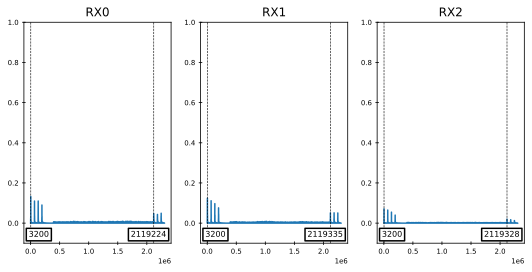

In [4]:
rx_data = bench_rx_data if DATASET == "bench" else test_rx_data

# bandpass filter
sos = signal.butter(20, (Fc-4e3, Fc+4e3), btype="band", output="sos", fs=fs_rx)
Ypb = signal.sosfilt(sos, rx_data, axis=-1)

#####################
# Estimate a
#####################
# correlate with a single chirp
Y_chirp = Ypb[..., :int(0.025*fs_rx)]

# get the index at roughly midpoint of signal
midpoint_i = int(len(Ypb[0])/2)

# get the index of the start of the chirps at the end of the signal
fig, axes = plt.subplots(1, 3, figsize=(9, 4))
# fig.suptitle("Ybp Chirp Correlation")

chirp_dist = np.zeros(N_RX)
for i in range(N_RX):
    corr_i = np.abs(signal.correlate(Ypb[i], Y_chirp[i], mode="same"))
    corr_avg = np.average(corr_i)

    # first chirp location in the preamble
    chirp_i0 = np.argmax(corr_i[:int(0.2*fs_rx)])
    # last chirp location in the postable
    chirp_i1 = np.argmax(corr_i[midpoint_i:-3 * int(0.2*fs_rx)]) + midpoint_i
    # distance in samples between chirps
    chirp_dist[i] = chirp_i1 - chirp_i0

    axes[i].plot(corr_i)
    mplm.axis_marker(x = chirp_i0, axes=axes[i], xformatter="{:.0f}")
    mplm.axis_marker(x = chirp_i1, axes=axes[i], xformatter="{:.0f}")
    axes[i].set_ylim([-0.1, 1])
    axes[i].set_title(f"RX{i}")

# time between three chirps is 0.75 (0.05 for chirp plus 0.2 silence for each chirp).
# at the receiver there are 191900 samples between each
# T_signal_rx = # 191900 * Ts_rx
T_signal = 8.2695 # length of TX data signal + the preamble in time
T_signal_rx = (chirp_dist) * Ts_rx # length of the RX data up to the ending chirps
a_est = (T_signal / T_signal_rx) - 1

print(f"a_est = {a_est}")
plt.show()

## Resampling

In [5]:
# resampling to remove the doppler shift, equation 7 in the paper. Since
# a is positive, the rx signal is compressed from the tx signal, and this resampling
# will stretch it out.
Ypb_re = []
for i in range(N_RX):
    Ypb_re.append(signal.resample_poly(Ypb[i], np.around((1 + a_est[i]) * 1e5), 1e5))
min_len = np.min([len(Ypb_re[i]) for i in range(N_RX)])
Ypb_re = np.array([yre[:min_len] for yre in Ypb_re])

# resample the RX data to 192kHz so it's the same as the transmitter
Ls = 192
Ms = 256
Ypb_re_txs = signal.resample_poly(Ypb_re, Ls, Ms, axis=-1)

# number of samples of the preamble chirp (1.5s long)
n0 = int(1.5 / Ts_tx)
# clip the chirp from the signal
Ypb_re_txs = Ypb_re_txs[..., n0:]

## Passband to Baseband

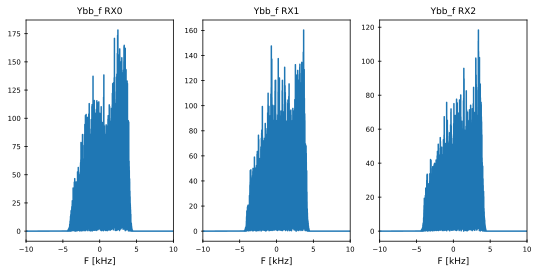

In [6]:
# convert to baseband
n = np.arange(0, len(Ypb_re_txs[0]))
Ybb = Ypb_re_txs * np.exp(-1j * Fc * 2* np.pi * n * Ts_tx)[None]

# lowpass filter
beta = 0.125 # roll off factor
n = np.arange(-sps*100, sps*100) 
t = np.arange(len(n)) * Ts_tx
R = utils.srrc_pulse(n, sps, beta)

# apply filter and plot results
Ybb_f = []
fig, axes = plt.subplots(1, 3, figsize=(9, 4))
for i in range(N_RX):
    Ybb_f.append(np.convolve(Ybb[i], R))
    utils.plot_fft(Ybb_f[i], fs_tx, ax=axes[i])
    axes[i].set_xlim([-10, 10])
    axes[i].set_title(f"Ybb_f RX{i}", fontsize=9)
    axes[i].set_xlabel("F [kHz]", fontsize=9)
Ybb_f = np.array(Ybb_f)
plt.show()

## CFO Compensation

In [7]:
def apply_cfo_vectorized(data, eps_vec, n0_vec):
    
    data_ds = np.zeros((len(n0_vec), (K+L-1)), dtype='complex128')
    n_sample_vec = np.zeros((len(n0_vec), (K+L-1)))
    # downsample the data to the 8k data rate, at each starting n0 point
    for i, n0_i in enumerate(n0_vec):
        data_ds[i] = data[n0_i:n0_i+(K+L-1)*sps:sps] 
    
        # cfo compensation exponential, vectorized over each eps value in the grid along the rows
        n_sample_vec[i] = np.arange(n0_i, n0_i+(K+L-1)*sps, sps)

    # CFO vector, shape is eps_vec, n0_vec, K+L-1
    cfo = np.exp(-1j * 2 * np.pi * eps_vec[..., None, None] * n_sample_vec[None] * Ts_tx)

    # apply the cfo compensation
    data_cfo = data_ds[None] * cfo

    # create modified DFT matrix (overlap add)
    k, m = np.meshgrid(np.arange(K+L-1), np.arange(K))
    Gm = np.exp(-1j * 2*np.pi * m * k / K)

    # apply DFT with matrix multiplication
    Zm = np.einsum("ij,...j->...i", Gm, data_cfo)

    # sum the power in the null subcarriers
    Pnull = np.sum(np.abs(Zm[..., null_subcarrier_i])**2, axis=-1)

    # get the index of the minimum power
    eps_min_i, n0_min_i = np.unravel_index(np.argmin(Pnull), Pnull.shape)
    # return the eps with the lowest null power, and the null power for that eps
    return eps_vec[eps_min_i], int(n0_vec[n0_min_i]), Pnull[eps_min_i, n0_min_i], Zm[eps_min_i, n0_min_i]

# 2D grid search over epsilong and starting index
n0_vec_course = np.arange(9000, 10000, 10)
eps_vec_course = np.arange(-5.0, 5.2, 0.2)

sym_n0 = np.zeros((N_RX, Wd))
sym_eps = np.zeros((N_RX, Wd))
null_pwr = np.zeros((N_RX, Wd))
# symbols after CFO compensation
Zm_w = np.zeros((N_RX, Wd, K), dtype="complex128")

for i in range(N_RX):
    w0_eps0, w0_n0, min_pwr0, Zm0 = apply_cfo_vectorized(Ybb_f[i], eps_vec_course, n0_vec_course)

    sym_n0[i, 0] = w0_n0

    for w in range(Wd):
        if w == 0:
            n0_w = w0_n0
            eps_w = w0_eps0
        else:
            n0_w = int(sym_n0[i, w-1]) + ((K + L -1) * sps)
            eps_w = sym_eps[i, w -1]

        # search each symbol over a finer range of epsilon and n0
        n0_vec_fine = np.arange(n0_w - (1 * sps), n0_w + (1 * sps) + 2, 2)
        eps_vec_fine = np.arange(eps_w - 0.4, eps_w + 0.5, 0.1)
        sym_eps[i, w], sym_n0[i, w], null_pwr[i, w], Zm_w[i, w] = apply_cfo_vectorized(Ybb_f[i], eps_vec_fine, n0_vec_fine)

        sys.stdout.write(f"\rRX {i} Symbol {w+1}/21: eps={sym_eps[i, w]:.2f}, n0={int(sym_n0[i, w])}, Null Power={null_pwr[i, w]:.2f}\t\t\t\t\t\t")

RX 2 Symbol 21/21: eps=0.70, n0=1088472, Null Power=0.47							

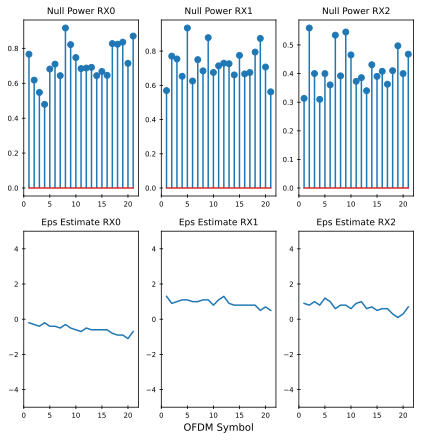

In [8]:
# save the output data
np.save(f"outputs/{DATASET}/Zm_w", Zm_w)
np.save(f"outputs/{DATASET}/eps", sym_eps)
np.save(f"outputs/{DATASET}/n0", sym_n0)

fig, axes = plt.subplots(2, 3, figsize=(7, 7))
for i in range(N_RX):
    axes[0, i].stem(np.arange(1, Wd+1), null_pwr[i])
    axes[0, i].set_title(f"Null Power RX{i}", fontsize=9)

    axes[1, i].plot(np.arange(1, Wd+1), sym_eps[i])
    axes[1, i].set_title(f"Eps Estimate RX{i}", fontsize=9)
    axes[1, i].set_ylim([-5, 5])
axes[1, 1].set_xlabel("OFDM Symbol")
plt.show()

## Least Square Channel Estimation

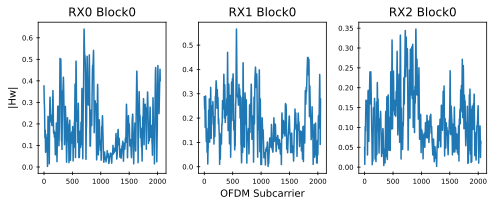

In [9]:
# get the pilot symbols from the data that has been doppler corrected
Zp = Zm_w[..., pilot_subcarrier_i]

# pilot symbols are only non=zero at the pilot indices
Ds = pilot_sym[pilot_subcarrier_i]

# form sparse DFT matrix that converts the channel vector h in time to the frequency
# domain channel gains for each pilot subcarrier
l, k = np.meshgrid(np.arange(L), pilot_subcarrier_i)
V = np.exp(-1j * 2*np.pi * l * k / K)

# time domain channel estimate using least square estimation, hls is WxL (21 x 200)
DsZp = np.einsum("i,...j->...ij", np.conj(Ds), Zp)
hls = (1 /Kp) * np.einsum("ij,...i->...j", np.conj(V), np.conj(Ds)[None, None] * Zp)

# convert back to the frequency domain for all subcarriers, Hw is W X K (21 X 2048)
l, k = np.meshgrid(np.arange(L), np.arange(K))
Gm = np.exp(-1j * 2*np.pi * l * k / K)
Hw = np.einsum("ij,...j->...i", Gm, hls)

fig, axes = plt.subplots(1, 3, figsize=(7, 3))
for i in range(N_RX):
    axes[i].plot(np.abs(Hw[i, 0]))
    axes[i].set_title(f"RX{i} Block{0}")
axes[1].set_xlabel("OFDM Subcarrier")
axes[0].set_ylabel("|Hw|");
fig.tight_layout()

## One-tap Equalizer

In [10]:
# first get the null subcarriers
Zn = Zm_w[..., null_subcarrier_i]

# get the data subcarriers
Zd = Zm_w[..., data_subcarrier_i]

# get the channel estimation for the data subcarriers
Hd = Hw[..., data_subcarrier_i]

# estimate the noise variance with the null subcarriers, for each ofdm symbol and receiver
nvar = (1 / (2*Sn)) * np.sum(np.abs(Zn)**2, axis=-1)

# distance of each received symbol to each of the qpsk symbols
d_x1, d_x2, d_x3, d_x4 = np.abs(Zd[None] - (Hd[None] * x[..., None, None, None]))**2 / (2 * nvar[None, ..., None])

def log_eA_eB(A, B):
    """ Compute log( e^A + e^B) """
    return np.max([A, B], axis=0) + np.log(1 + np.exp(-np.abs(B - A)))

Lb1 = log_eA_eB(-d_x1, -d_x3) - log_eA_eB(-d_x2, -d_x4)
Lb2 = log_eA_eB(-d_x1, -d_x2) - log_eA_eB(-d_x3, -d_x4)

# combine into a single LR vector for each OFDM symbol
LR = np.zeros((3, Wd, Sd*2))
LR[..., ::2] = Lb1
LR[..., 1::2] = Lb2

np.save(f"outputs/{DATASET}/LR", LR)

## Decoding Seperately

Number of Errors
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [562 508 707 807 774 347   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [529 607 698 767 775 797 745 403 312 216 235 239   0 285   0 256   0   0
  427 337 427]]
BER:  ['0.0000', '0.0527', '0.1262']


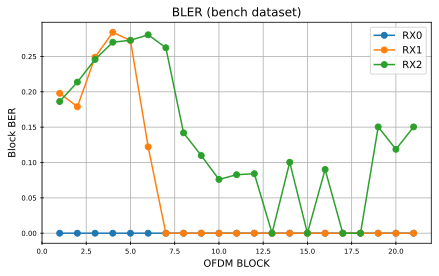

In [11]:
app_code_seperate = np.zeros(shape=(3, Wd, LDPC_CODELEN))
# loop over each receiver
for r in range(3):
    # loop over each OFDM symbol
    for w in range(Wd):
        
        LR_in_de = np.zeros(LDPC_CODELEN)
        LR_in_de[iterleaver - 1] = LR[r, w]
        app_code_seperate[r, w] = np.array(pbe.ldpc_decoder(ldpc_address, LR_in_de, LDPC_CODELEN))

# compute BER for each OFDM block seperately
est_code = (app_code_seperate < 0).astype(int)
wec_sep = np.sum(np.abs(est_code - expected_code), axis=-1) # bit error number
wer_sep = wec_sep / LDPC_CODELEN

# compute total BER, skip the first pilot OFDM symbol
ber_sep = np.sum(wec_sep[:, 1:], axis=-1) / (LDPC_CODELEN * Wd)

fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(np.arange(1, Wd+1), wer_sep.T, marker='o')
ax1.set_ylabel("Block BER")
ax1.legend([f"RX{i}" for i in range(N_RX)])
ax1.set_xlabel("OFDM BLOCK")
ax1.grid(True)
ax1.set_title(f"BLER ({DATASET} dataset)")

print("Number of Errors\n", wec_sep)
print("BER: ", [f"{ber_sep[i]:0.4f}" for i in range(N_RX)])

## Maximum Ratio Receiver Combining (MRRC)
## 2 Receivers

In [12]:
Hd_2 = Hd[:2]

# combine all the receivers together using MRRC
H_norm2_sqr = np.einsum("i..., i...->...", np.conjugate(Hd_2), Hd_2)
H_norm2 = np.sqrt(H_norm2_sqr)
Qd = np.einsum("i..., i...->...", np.conjugate(Hd_2), Zd[:2]) / H_norm2

# noise variance of the combined signal should be the same as the single case because
# of the scaling using H_norm
nvar_c = (1 / (2 * H_norm2_sqr)) * np.sum(2 * nvar[:2, ..., None] * np.conjugate(Hd_2) * Hd_2, axis=0)

# distance of each received symbol to each of the qpsk symbols
d_x1, d_x2, d_x3, d_x4 = np.abs(Qd[None] - (H_norm2[None] * x[..., None, None]))**2 / (2 * nvar_c[None])

Lb1_c = log_eA_eB(-d_x1, -d_x3) - log_eA_eB(-d_x2, -d_x4)
Lb2_c = log_eA_eB(-d_x1, -d_x2) - log_eA_eB(-d_x3, -d_x4)

# combine into a single LR vector for each OFDM symbol
LR_c = np.zeros((Wd, Sd*2))
LR_c[..., ::2] = Lb1_c.real
LR_c[..., 1::2] = Lb2_c.real

app_code_comb = np.zeros(shape=(Wd, LDPC_CODELEN))
# loop over each OFDM symbol
for w in range(Wd):
    LR_in_de = np.zeros(LDPC_CODELEN)
    LR_in_de[iterleaver - 1] = LR_c[w]
    app_code_comb[w] = np.array(pbe.ldpc_decoder(ldpc_address, LR_in_de, LDPC_CODELEN))

np.save(f"outputs/{DATASET}/mrrc_output_code.npy", app_code_comb)

# compute BER over each OFDM block
est_code = (app_code_comb < 0).astype(int)
wec_comb = np.sum(np.abs(est_code - expected_code), axis=-1) # bit error number
wer_comb = wec_comb / LDPC_CODELEN

# compute total BER
ber_comb = np.sum(wec_comb) / (LDPC_CODELEN * Wd)

print("Number of Errors (2RX)", wec_comb)
print("BER", ber_comb)

Number of Errors (2RX) [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BER 1.676727028839705e-05


## 3 Receivers

In [13]:
# combine all the receivers together using MRRC
H_norm_sqr = np.einsum("i..., i...->...", np.conjugate(Hd), Hd)
H_norm = np.sqrt(H_norm_sqr)
Qd = np.einsum("i..., i...->...", np.conjugate(Hd), Zd) / H_norm

# noise variance of the combined signal should be the same as the single case because
# of the scaling using H_norm
nvar_c = (1 / (2 * H_norm_sqr)) * np.sum(2 * nvar[..., None] * np.conjugate(Hd) * Hd, axis=0)

# distance of each received symbol to each of the qpsk symbols
d_x1, d_x2, d_x3, d_x4 = np.abs(Qd[None] - (H_norm[None] * x[..., None, None]))**2 / (2 * nvar_c[None])

Lb1_c = log_eA_eB(-d_x1, -d_x3) - log_eA_eB(-d_x2, -d_x4)
Lb2_c = log_eA_eB(-d_x1, -d_x2) - log_eA_eB(-d_x3, -d_x4)

# combine into a single LR vector for each OFDM symbol
LR_c = np.zeros((Wd, Sd*2))
LR_c[..., ::2] = Lb1_c.real
LR_c[..., 1::2] = Lb2_c.real

app_code_comb = np.zeros(shape=(Wd, LDPC_CODELEN))
# loop over each OFDM symbol
for w in range(Wd):
    LR_in_de = np.zeros(LDPC_CODELEN)
    LR_in_de[iterleaver - 1] = LR_c[w]
    app_code_comb[w] = np.array(pbe.ldpc_decoder(ldpc_address, LR_in_de, LDPC_CODELEN))

np.save(f"outputs/{DATASET}/mrrc_output_code.npy", app_code_comb)

# compute BER over each OFDM block
est_code = (app_code_comb < 0).astype(int)
wec_comb = np.sum(np.abs(est_code - expected_code), axis=-1) # bit error number
wer_comb = wec_comb / LDPC_CODELEN

# compute total BER
ber_comb = np.sum(wec_comb) / (LDPC_CODELEN * Wd)

print("Number of Errors (3RX)", wec_comb)
print("BER", ber_comb)

Number of Errors (3RX) [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
BER 1.676727028839705e-05


In [14]:
from IPython.display import display, HTML, Javascript
from ipylab import JupyterFrontEnd
import subprocess
app = JupyterFrontEnd()

display(
    HTML(
        "<style>"
        ".jp-Cell { overflow-x: visible; overflow: visible; "
        "width: 95%; max-width: 1000px; "
        "margin-left: auto; margin-right: auto; }"
        "img {"
        "width: 90%;"
        "height: 100%;}"
        ".jp-Cell-inputWrapper { width: 95%; overflow-x: visible; overflow: visible;}"
        "</style>"
    )
)

app.commands.execute("docmanager:save")
subprocess.run(f"jupyter nbconvert --to html project_part3.ipynb --output \"outputs/{DATASET}/project_part3_{DATASET}\"", shell=True)
app.commands.execute("docmanager:save");

[NbConvertApp] Converting notebook project_part3.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1659083 bytes to outputs/bench/project_part3_bench.html
